In [41]:
import pandas as pd
#pip install prophet
#pip install ipywidgets
from prophet import Prophet
import itertools
import numpy as np

# import sys
# sys.path.append('/Users/thomas_metral/code/thomas-metral/metro_seoul')
# print(sys.path)


from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
import matplotlib.pyplot as plt
import seaborn as sns
from metro_app.ml_logic.preprocess import general_preprocessing, model_data_preprocessing, preprocess_lstm, prophet_preprocessing_one_station

from metro_app.ml_logic.model import train_prophet, predict_prophet
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error
import datetime
import plotly.express as px


In [24]:
df = pd.read_csv('/Users/thomas_metral/code/thomas-metral/metro_seoul/raw_data/crowd2020-2023.csv')


/var/folders/zn/b4l6fdhd4fs52t3wxt1d7kn40000gn/T/ipykernel_64651/2845828255.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/thomas_metral/code/thomas-metral/metro_seoul/raw_data/crowd2020-2023.csv')


## Multi station

In [7]:
df1 = general_preprocessing(df)
df1 = model_data_preprocessing(df1)
df1.reset_index(inplace=True)
df1 = df1.groupby(['datetime', 'station_name', 'station_number', 'line'])['value'].sum().reset_index()
df1


/Users/thomas_metral/code/thomas-metral/metro_seoul/metro_app/ml_logic/preprocess.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])
/Users/thomas_metral/code/thomas-metral/metro_seoul/metro_app/ml_logic/preprocess.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['line'] = df['line'].astype('int')


,datetime,station_name,station_number,line,value
0,2020-01-01 01:00:00,Achasan(Rear Entrance to Seoul Children's Gran...,2546,5,0
1,2020-01-01 01:00:00,Aeogae,2531,5,0
2,2020-01-01 01:00:00,Ahyeon,242,2,0
3,2020-01-01 01:00:00,Amsa,2811,8,0
4,2020-01-01 01:00:00,Anam(Korea Univ. Hospital),2640,6,0
...,...,...,...,...,...
8452123,2023-07-01 00:00:00,Yeouido,2527,5,0
8452124,2023-07-01 00:00:00,Yeouinaru,2528,5,0
8452125,2023-07-01 00:00:00,Yongdap,244,2,0
8452126,2023-07-01 00:00:00,Yongdu (Dongdaemun-gu Office),250,2,0


In [10]:
station_charlotte = [['Dongjak (Seoul National Cemetery)', 4],
 ['Gangnam', 2],
 ['Gireum', 4],
 ['Guro Digital Complex', 2],
 ['Gwanghwamun(Sejong Center for the Performing Arts)', 5],
 ['Hongik Univ.', 2],
 ['Itaewon', 6],
 ['Jamsilsaenae', 2],
 ['Mok-dong', 5],
 ['Nokbeon', 3],
 ['Seongsu', 2],
 ['Seoul Station', 1],
 ['Seoul Station', 4],
 ['World Cup Stadium(Seongsan)', 6],
 ['Yeonsinnae', 3],
 ['Yeonsinnae', 6],
 ['Yeouido', 5]]

mapes = []

for i in range(len(station_charlotte)):

    data = df1[(df1['station_name'] == station_charlotte[i][0]) &
                (df1['line'] == station_charlotte[i][1])]
    data = data.rename(columns={'datetime':'ds', 'value' : 'y'})

    #lenght of test data
    days = 2

    # index = round(train_size*df_156.shape[0])
    data_train = data.iloc[:-24*days]
    data_test = data.iloc[-24*days:]

    #shorten the train data
    data_train = data_train.iloc[-24*500:]

    data_train['is_morning_peak'] = ((data_train['ds'].dt.hour == 8) & (data_train['ds'].dt.dayofweek <= 5)).astype(int)
    data_train['is_afternoon_peak'] = ((data_train['ds'].dt.hour == 18) & (data_train['ds'].dt.dayofweek <= 5)).astype(int)
    data_train['is_closed'] = ((data_train['ds'].dt.hour >= 0) & (data_train['ds'].dt.hour <= 4)).astype(int)

    model = Prophet(changepoint_prior_scale=0.002, seasonality_prior_scale=12.0,
                    holidays_prior_scale=10.0, seasonality_mode='multiplicative', daily_seasonality=True)
    model.add_regressor('is_morning_peak')
    model.add_regressor('is_afternoon_peak')
    model.add_regressor('is_closed')
    model.add_country_holidays(country_name='SK')
    print(data_train)
    model.fit(data_train)

    # Create a future dataframe for predictions
    future = model.make_future_dataframe(periods=days*24, include_history=False, freq='h')  # Forecasting for the next week
    future['is_morning_peak'] = ((future['ds'].dt.hour >= 7) & (future['ds'].dt.hour <= 9)).astype(int)
    future['is_afternoon_peak'] = ((future['ds'].dt.hour >= 17) & (future['ds'].dt.hour <= 19)).astype(int)
    future['is_closed'] = ((future['ds'].dt.hour >= 0) & (future['ds'].dt.hour <= 4)).astype(int)
    future['is_weekend'] = (future['ds'].dt.dayofweek >= 5).astype(int)

    # Generate predictions
    forecast = model.predict(future)
    prediction = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

    result = mape(prediction['yhat'].values, data_test['y'].values)

    mapes.append(f"{station_charlotte[i][0]} {station_charlotte[i][1]} : {result}")


                         ds                       station_name station_number  \
61      2020-01-01 01:00:00  Dongjak (Seoul National Cemetery)            431   
336     2020-01-01 02:00:00  Dongjak (Seoul National Cemetery)            431   
611     2020-01-01 03:00:00  Dongjak (Seoul National Cemetery)            431   
886     2020-01-01 04:00:00  Dongjak (Seoul National Cemetery)            431   
1161    2020-01-01 05:00:00  Dongjak (Seoul National Cemetery)            431   
...                     ...                                ...            ...   
8450821 2023-06-30 20:00:00  Dongjak (Seoul National Cemetery)            431   
8451094 2023-06-30 21:00:00  Dongjak (Seoul National Cemetery)            431   
8451367 2023-06-30 22:00:00  Dongjak (Seoul National Cemetery)            431   
8451640 2023-06-30 23:00:00  Dongjak (Seoul National Cemetery)            431   
8451913 2023-07-01 00:00:00  Dongjak (Seoul National Cemetery)            431   

         line    y  
61    

16:01:33 - cmdstanpy - INFO - Chain [1] start processing
16:01:35 - cmdstanpy - INFO - Chain [1] done processing


                         ds station_name station_number  line     y
81      2020-01-01 01:00:00      Gangnam            222     2     0
356     2020-01-01 02:00:00      Gangnam            222     2     0
631     2020-01-01 03:00:00      Gangnam            222     2     0
906     2020-01-01 04:00:00      Gangnam            222     2     0
1181    2020-01-01 05:00:00      Gangnam            222     2  2043
...                     ...          ...            ...   ...   ...
8450842 2023-06-30 20:00:00      Gangnam            222     2  8938
8451115 2023-06-30 21:00:00      Gangnam            222     2  9158
8451388 2023-06-30 22:00:00      Gangnam            222     2  9845
8451661 2023-06-30 23:00:00      Gangnam            222     2  6245
8451934 2023-07-01 00:00:00      Gangnam            222     2     0

[30648 rows x 5 columns]
                         ds station_name station_number  line     y  \
5167663 2022-02-14 01:00:00      Gangnam            222     2     0   
5167937 2022-02-

16:01:35 - cmdstanpy - INFO - Chain [1] start processing
16:01:36 - cmdstanpy - INFO - Chain [1] done processing


                         ds station_name station_number  line     y
90      2020-01-01 01:00:00       Gireum            417     4     0
365     2020-01-01 02:00:00       Gireum            417     4     0
640     2020-01-01 03:00:00       Gireum            417     4     0
915     2020-01-01 04:00:00       Gireum            417     4     0
1190    2020-01-01 05:00:00       Gireum            417     4   201
...                     ...          ...            ...   ...   ...
8450851 2023-06-30 20:00:00       Gireum            417     4  1906
8451124 2023-06-30 21:00:00       Gireum            417     4  1807
8451397 2023-06-30 22:00:00       Gireum            417     4  1745
8451670 2023-06-30 23:00:00       Gireum            417     4  1239
8451943 2023-07-01 00:00:00       Gireum            417     4     0

[30648 rows x 5 columns]
                         ds station_name station_number  line     y  \
5167672 2022-02-14 01:00:00       Gireum            417     4     0   
5167946 2022-02-

16:01:36 - cmdstanpy - INFO - Chain [1] start processing
16:01:37 - cmdstanpy - INFO - Chain [1] done processing


                         ds          station_name station_number  line     y
100     2020-01-01 01:00:00  Guro Digital Complex            232     2     0
375     2020-01-01 02:00:00  Guro Digital Complex            232     2     0
650     2020-01-01 03:00:00  Guro Digital Complex            232     2     0
925     2020-01-01 04:00:00  Guro Digital Complex            232     2     0
1200    2020-01-01 05:00:00  Guro Digital Complex            232     2   815
...                     ...                   ...            ...   ...   ...
8450860 2023-06-30 20:00:00  Guro Digital Complex            232     2  5613
8451133 2023-06-30 21:00:00  Guro Digital Complex            232     2  5362
8451406 2023-06-30 22:00:00  Guro Digital Complex            232     2  4904
8451679 2023-06-30 23:00:00  Guro Digital Complex            232     2  3421
8451952 2023-07-01 00:00:00  Guro Digital Complex            232     2     0

[30648 rows x 5 columns]
                         ds          station_name 

16:01:38 - cmdstanpy - INFO - Chain [1] start processing
16:01:38 - cmdstanpy - INFO - Chain [1] done processing


                         ds  \
104     2020-01-01 01:00:00   
379     2020-01-01 02:00:00   
654     2020-01-01 03:00:00   
929     2020-01-01 04:00:00   
1204    2020-01-01 05:00:00   
...                     ...   
8450864 2023-06-30 20:00:00   
8451137 2023-06-30 21:00:00   
8451410 2023-06-30 22:00:00   
8451683 2023-06-30 23:00:00   
8451956 2023-07-01 00:00:00   

                                              station_name station_number  \
104      Gwanghwamun(Sejong Center for the Performing A...           2534   
379      Gwanghwamun(Sejong Center for the Performing A...           2534   
654      Gwanghwamun(Sejong Center for the Performing A...           2534   
929      Gwanghwamun(Sejong Center for the Performing A...           2534   
1204     Gwanghwamun(Sejong Center for the Performing A...           2534   
...                                                    ...            ...   
8450864  Gwanghwamun(Sejong Center for the Performing A...           2534   
8451137  Gw

16:01:39 - cmdstanpy - INFO - Chain [1] start processing
16:01:39 - cmdstanpy - INFO - Chain [1] done processing


                         ds  station_name station_number  line      y
118     2020-01-01 01:00:00  Hongik Univ.            239     2      0
393     2020-01-01 02:00:00  Hongik Univ.            239     2      0
668     2020-01-01 03:00:00  Hongik Univ.            239     2      0
943     2020-01-01 04:00:00  Hongik Univ.            239     2      0
1218    2020-01-01 05:00:00  Hongik Univ.            239     2   5650
...                     ...           ...            ...   ...    ...
8450881 2023-06-30 20:00:00  Hongik Univ.            239     2  10063
8451154 2023-06-30 21:00:00  Hongik Univ.            239     2  10295
8451427 2023-06-30 22:00:00  Hongik Univ.            239     2  10391
8451700 2023-06-30 23:00:00  Hongik Univ.            239     2   7343
8451973 2023-07-01 00:00:00  Hongik Univ.            239     2      0

[30648 rows x 5 columns]
                         ds  station_name station_number  line     y  \
5167702 2022-02-14 01:00:00  Hongik Univ.            239     2

16:01:40 - cmdstanpy - INFO - Chain [1] start processing
16:01:41 - cmdstanpy - INFO - Chain [1] done processing


                         ds station_name station_number  line     y
127     2020-01-01 01:00:00      Itaewon           2631     6     0
402     2020-01-01 02:00:00      Itaewon           2631     6     0
677     2020-01-01 03:00:00      Itaewon           2631     6     0
952     2020-01-01 04:00:00      Itaewon           2631     6     0
1227    2020-01-01 05:00:00      Itaewon           2631     6  4026
...                     ...          ...            ...   ...   ...
8450890 2023-06-30 20:00:00      Itaewon           2631     6  1939
8451163 2023-06-30 21:00:00      Itaewon           2631     6  1892
8451436 2023-06-30 22:00:00      Itaewon           2631     6  2338
8451709 2023-06-30 23:00:00      Itaewon           2631     6  2032
8451982 2023-07-01 00:00:00      Itaewon           2631     6     0

[30648 rows x 5 columns]
                         ds station_name station_number  line     y  \
5167711 2022-02-14 01:00:00      Itaewon           2631     6     0   
5167985 2022-02-

16:01:41 - cmdstanpy - INFO - Chain [1] start processing
16:01:42 - cmdstanpy - INFO - Chain [1] done processing


                         ds  station_name station_number  line     y
131     2020-01-01 01:00:00  Jamsilsaenae            217     2     0
406     2020-01-01 02:00:00  Jamsilsaenae            217     2     0
681     2020-01-01 03:00:00  Jamsilsaenae            217     2     0
956     2020-01-01 04:00:00  Jamsilsaenae            217     2     0
1231    2020-01-01 05:00:00  Jamsilsaenae            217     2   425
...                     ...           ...            ...   ...   ...
8450894 2023-06-30 20:00:00  Jamsilsaenae            217     2  2554
8451167 2023-06-30 21:00:00  Jamsilsaenae            217     2  2384
8451440 2023-06-30 22:00:00  Jamsilsaenae            217     2  2816
8451713 2023-06-30 23:00:00  Jamsilsaenae            217     2  2133
8451986 2023-07-01 00:00:00  Jamsilsaenae            217     2     0

[30648 rows x 5 columns]
                         ds  station_name station_number  line     y  \
5167715 2022-02-14 01:00:00  Jamsilsaenae            217     2     0   
51

16:01:43 - cmdstanpy - INFO - Chain [1] start processing
16:01:44 - cmdstanpy - INFO - Chain [1] done processing


                         ds station_name station_number  line     y
164     2020-01-01 01:00:00     Mok-dong           2521     5     0
439     2020-01-01 02:00:00     Mok-dong           2521     5     0
714     2020-01-01 03:00:00     Mok-dong           2521     5     0
989     2020-01-01 04:00:00     Mok-dong           2521     5     0
1264    2020-01-01 05:00:00     Mok-dong           2521     5   214
...                     ...          ...            ...   ...   ...
8450927 2023-06-30 20:00:00     Mok-dong           2521     5  1644
8451200 2023-06-30 21:00:00     Mok-dong           2521     5  1560
8451473 2023-06-30 22:00:00     Mok-dong           2521     5  1789
8451746 2023-06-30 23:00:00     Mok-dong           2521     5   842
8452019 2023-07-01 00:00:00     Mok-dong           2521     5     0

[30648 rows x 5 columns]
                         ds station_name station_number  line     y  \
5167748 2022-02-14 01:00:00     Mok-dong           2521     5     0   
5168022 2022-02-

16:01:44 - cmdstanpy - INFO - Chain [1] start processing
16:01:45 - cmdstanpy - INFO - Chain [1] done processing


                         ds station_name station_number  line     y
181     2020-01-01 01:00:00      Nokbeon            313     3     0
456     2020-01-01 02:00:00      Nokbeon            313     3     0
731     2020-01-01 03:00:00      Nokbeon            313     3     0
1006    2020-01-01 04:00:00      Nokbeon            313     3     0
1281    2020-01-01 05:00:00      Nokbeon            313     3   136
...                     ...          ...            ...   ...   ...
8450945 2023-06-30 20:00:00      Nokbeon            313     3  1362
8451218 2023-06-30 21:00:00      Nokbeon            313     3  1219
8451491 2023-06-30 22:00:00      Nokbeon            313     3  1175
8451764 2023-06-30 23:00:00      Nokbeon            313     3   829
8452037 2023-07-01 00:00:00      Nokbeon            313     3     0

[30648 rows x 5 columns]
                         ds station_name station_number  line     y  \
5167766 2022-02-14 01:00:00      Nokbeon            313     3     0   
5168040 2022-02-

16:01:46 - cmdstanpy - INFO - Chain [1] start processing
16:01:46 - cmdstanpy - INFO - Chain [1] done processing


                         ds station_name station_number  line     y
214     2020-01-01 01:00:00      Seongsu            211     2     0
489     2020-01-01 02:00:00      Seongsu            211     2     0
764     2020-01-01 03:00:00      Seongsu            211     2     0
1039    2020-01-01 04:00:00      Seongsu            211     2     0
1314    2020-01-01 05:00:00      Seongsu            211     2   198
...                     ...          ...            ...   ...   ...
8450976 2023-06-30 20:00:00      Seongsu            211     2  3814
8451249 2023-06-30 21:00:00      Seongsu            211     2  3321
8451522 2023-06-30 22:00:00      Seongsu            211     2  2597
8451795 2023-06-30 23:00:00      Seongsu            211     2  1588
8452068 2023-07-01 00:00:00      Seongsu            211     2     0

[30648 rows x 5 columns]
                         ds station_name station_number  line     y  \
5167797 2022-02-14 01:00:00      Seongsu            211     2     0   
5168071 2022-02-

16:01:47 - cmdstanpy - INFO - Chain [1] start processing
16:01:47 - cmdstanpy - INFO - Chain [1] done processing


                         ds   station_name station_number  line     y
218     2020-01-01 01:00:00  Seoul Station            150     1     0
493     2020-01-01 02:00:00  Seoul Station            150     1     0
768     2020-01-01 03:00:00  Seoul Station            150     1     0
1043    2020-01-01 04:00:00  Seoul Station            150     1     0
1318    2020-01-01 05:00:00  Seoul Station            150     1   591
...                     ...            ...            ...   ...   ...
8450980 2023-06-30 20:00:00  Seoul Station            150     1  5140
8451253 2023-06-30 21:00:00  Seoul Station            150     1  5433
8451526 2023-06-30 22:00:00  Seoul Station            150     1  3911
8451799 2023-06-30 23:00:00  Seoul Station            150     1  1813
8452072 2023-07-01 00:00:00  Seoul Station            150     1     0

[30648 rows x 5 columns]
                         ds   station_name station_number  line     y  \
5167801 2022-02-14 01:00:00  Seoul Station            150    

16:01:48 - cmdstanpy - INFO - Chain [1] start processing
16:01:49 - cmdstanpy - INFO - Chain [1] done processing


                         ds   station_name station_number  line     y
219     2020-01-01 01:00:00  Seoul Station            426     4     0
494     2020-01-01 02:00:00  Seoul Station            426     4     0
769     2020-01-01 03:00:00  Seoul Station            426     4     0
1044    2020-01-01 04:00:00  Seoul Station            426     4     0
1319    2020-01-01 05:00:00  Seoul Station            426     4   174
...                     ...            ...            ...   ...   ...
8450981 2023-06-30 20:00:00  Seoul Station            426     4  1470
8451254 2023-06-30 21:00:00  Seoul Station            426     4  1329
8451527 2023-06-30 22:00:00  Seoul Station            426     4  1282
8451800 2023-06-30 23:00:00  Seoul Station            426     4   677
8452073 2023-07-01 00:00:00  Seoul Station            426     4     0

[30648 rows x 5 columns]
                         ds   station_name station_number  line     y  \
5167802 2022-02-14 01:00:00  Seoul Station            426    

16:01:49 - cmdstanpy - INFO - Chain [1] start processing
16:01:50 - cmdstanpy - INFO - Chain [1] done processing


                         ds                 station_name station_number  line  \
258     2020-01-01 01:00:00  World Cup Stadium(Seongsan)           2620     6   
533     2020-01-01 02:00:00  World Cup Stadium(Seongsan)           2620     6   
808     2020-01-01 03:00:00  World Cup Stadium(Seongsan)           2620     6   
1083    2020-01-01 04:00:00  World Cup Stadium(Seongsan)           2620     6   
1358    2020-01-01 05:00:00  World Cup Stadium(Seongsan)           2620     6   
...                     ...                          ...            ...   ...   
8451019 2023-06-30 20:00:00  World Cup Stadium(Seongsan)           2620     6   
8451292 2023-06-30 21:00:00  World Cup Stadium(Seongsan)           2620     6   
8451565 2023-06-30 22:00:00  World Cup Stadium(Seongsan)           2620     6   
8451838 2023-06-30 23:00:00  World Cup Stadium(Seongsan)           2620     6   
8452111 2023-07-01 00:00:00  World Cup Stadium(Seongsan)           2620     6   

           y  
258        0

16:01:51 - cmdstanpy - INFO - Chain [1] start processing
16:01:51 - cmdstanpy - INFO - Chain [1] done processing


                         ds station_name station_number  line     y
269     2020-01-01 01:00:00   Yeonsinnae            311     3     0
544     2020-01-01 02:00:00   Yeonsinnae            311     3     0
819     2020-01-01 03:00:00   Yeonsinnae            311     3     0
1094    2020-01-01 04:00:00   Yeonsinnae            311     3     0
1369    2020-01-01 05:00:00   Yeonsinnae            311     3   679
...                     ...          ...            ...   ...   ...
8451030 2023-06-30 20:00:00   Yeonsinnae            311     3  3546
8451303 2023-06-30 21:00:00   Yeonsinnae            311     3  3042
8451576 2023-06-30 22:00:00   Yeonsinnae            311     3  2992
8451849 2023-06-30 23:00:00   Yeonsinnae            311     3  2067
8452122 2023-07-01 00:00:00   Yeonsinnae            311     3     0

[30648 rows x 5 columns]
                         ds station_name station_number  line     y  \
5167851 2022-02-14 01:00:00   Yeonsinnae            311     3     0   
5168125 2022-02-

16:01:52 - cmdstanpy - INFO - Chain [1] start processing
16:01:52 - cmdstanpy - INFO - Chain [1] done processing


                         ds station_name station_number  line  y
66415   2020-01-11 01:00:00   Yeonsinnae           2615     6  0
66692   2020-01-11 02:00:00   Yeonsinnae           2615     6  0
66969   2020-01-11 03:00:00   Yeonsinnae           2615     6  0
67246   2020-01-11 04:00:00   Yeonsinnae           2615     6  0
67523   2020-01-11 05:00:00   Yeonsinnae           2615     6  0
...                     ...          ...            ...   ... ..
8424894 2023-06-26 20:00:00   Yeonsinnae           2615     6  0
8425167 2023-06-26 21:00:00   Yeonsinnae           2615     6  0
8425440 2023-06-26 22:00:00   Yeonsinnae           2615     6  0
8425713 2023-06-26 23:00:00   Yeonsinnae           2615     6  0
8425986 2023-06-27 00:00:00   Yeonsinnae           2615     6  0

[4872 rows x 5 columns]
                         ds station_name station_number  line  y  \
66415   2020-01-11 01:00:00   Yeonsinnae           2615     6  0   
66692   2020-01-11 02:00:00   Yeonsinnae           2615    

16:01:53 - cmdstanpy - INFO - Chain [1] start processing
16:01:54 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
mapes


['Dongjak (Seoul National Cemetery) 4 : 0.44767686964798187',
 'Gangnam 2 : 0.36723917955810564',
 'Gireum 4 : 0.3937163045630341',
 'Guro Digital Complex 2 : 0.4104422373034778',
 'Gwanghwamun(Sejong Center for the Performing Arts) 5 : 0.46988274901135046',
 'Hongik Univ. 2 : 0.3626736108370661',
 'Itaewon 6 : 0.3964622954276266',
 'Jamsilsaenae 2 : 0.3749862969088007',
 'Mok-dong 5 : 0.391478945050503',
 'Nokbeon 3 : 0.3823872823300582',
 'Seongsu 2 : 0.4291267200948345',
 'Seoul Station 1 : 0.378007073321204',
 'Seoul Station 4 : 0.3844574255710978',
 'World Cup Stadium(Seongsan) 6 : 0.4595313302137594',
 'Yeonsinnae 3 : 0.3535029540106051',
 'Yeonsinnae 6 : 0.0',
 'Yeouido 5 : 0.43913661450212577']

## Improving params

In [31]:
df = pd.read_csv('/Users/thomas_metral/code/thomas-metral/metro_seoul/raw_data/crowd2020-2023.csv')
df1 = general_preprocessing(df)
df2 = model_data_preprocessing(df1)
df2.reset_index(inplace=True)
df3 = df2.groupby(['datetime', 'station_name', 'station_number', 'line'])['value'].sum().reset_index()
data = df3[(df3['station_name'] == 'Seongsu') &
                (df3['line'] == 2)]

data = data.rename(columns={'datetime':'ds', 'value' : 'y'})


/var/folders/zn/b4l6fdhd4fs52t3wxt1d7kn40000gn/T/ipykernel_64651/364441125.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/thomas_metral/code/thomas-metral/metro_seoul/raw_data/crowd2020-2023.csv')
/Users/thomas_metral/code/thomas-metral/metro_seoul/metro_app/ml_logic/preprocess.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])
/Users/thomas_metral/code/thomas-metral/metro_seoul/metro_app/ml_logic/preprocess.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

### Feature engineering

In [149]:
#lenght of test data
days = 5

# index = round(train_size*df_156.shape[0])
data_train = data.iloc[:-24*days]
data_test = data.iloc[-24*days:]

#shorten the train data
data_train = data_train.iloc[-24*500:]

data_train['is_morning_peak'] = ((data_train['ds'].dt.hour == 8) & (data_train['ds'].dt.dayofweek <= 5)).astype(int)
data_train['is_afternoon_peak'] = ((data_train['ds'].dt.hour == 18) & (data_train['ds'].dt.dayofweek <= 5)).astype(int)
data_train['is_closed'] = ((data_train['ds'].dt.hour >= 0) & (data_train['ds'].dt.hour <= 4)).astype(int)


In [153]:
#instantiate and fit the model
model = Prophet(changepoint_prior_scale=0.2, seasonality_prior_scale=10.0,
                holidays_prior_scale=10.0, seasonality_mode='multiplicative')
# model.add_regressor('is_morning_peak')
# model.add_regressor('is_afternoon_peak')

model.add_regressor('is_closed', mode='multiplicative')
model.add_seasonality(name='morning_peak', period=1, fourier_order=8, condition_name='is_morning_peak')
model.add_seasonality(name='afternoon_peak', period=1, fourier_order=8, condition_name='is_afternoon_peak')
model.add_country_holidays(country_name='SK')
model.fit(data_train)

# Create a future dataframe for predictions
future = model.make_future_dataframe(periods=days*24, include_history=False, freq='h')  # Forecasting for the next week
future['is_morning_peak'] = ((future['ds'].dt.hour >= 7) & (future['ds'].dt.hour <= 9)).astype(int)
future['is_afternoon_peak'] = ((future['ds'].dt.hour >= 17) & (future['ds'].dt.hour <= 19)).astype(int)
future['is_closed'] = ((future['ds'].dt.hour >= 0) & (future['ds'].dt.hour <= 4)).astype(int)
future['is_weekend'] = (future['ds'].dt.dayofweek >= 5).astype(int)

# Generate predictions
forecast = model.predict(future)
prediction = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

mape(prediction['yhat'].values, data_test['y'].values)


18:01:34 - cmdstanpy - INFO - Chain [1] start processing
18:01:37 - cmdstanpy - INFO - Chain [1] done processing


0.3450534607843332

In [151]:
comparaison = prediction.merge(data_test, on='ds')
fig = px.line(comparaison, x="ds", y=["y", 'yhat'])
# sns.lineplot(x=prediction['ds'], y=prediction['yhat'])
# sns.lineplot(x=data_test['ds'], y=data_test['y'])
fig.show()


### CROSS VAL

In [136]:
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1],
    'seasonality_prior_scale': [0.1, 1.0, 10.0],
    'holidays_prior_scale' : [1.0, 10.0, 15.0],
    'seasonality_mode' : ['multiplicative']

}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params)  # Fit model with given params
    m.add_regressor('is_closed', mode='multiplicative')
    m.add_seasonality(name='morning_peak', period=1, fourier_order=8, condition_name='is_morning_peak')
    m.add_seasonality(name='afternoon_peak', period=1, fourier_order=8, condition_name='is_afternoon_peak')
    m.add_country_holidays(country_name='SK')
    m.fit(data_train)
    df_cv = cross_validation(m, initial='400 days', period='100 days', horizon = '2 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)
tuning_results.iloc[rmses.index(min(rmses))]


17:51:44 - cmdstanpy - INFO - Chain [1] start processing
17:51:45 - cmdstanpy - INFO - Chain [1] done processing
17:51:46 - cmdstanpy - INFO - Chain [1] start processing
17:51:46 - cmdstanpy - INFO - Chain [1] done processing
17:51:47 - cmdstanpy - INFO - Chain [1] start processing
17:51:47 - cmdstanpy - INFO - Chain [1] done processing
17:51:49 - cmdstanpy - INFO - Chain [1] start processing
17:51:49 - cmdstanpy - INFO - Chain [1] done processing
17:51:50 - cmdstanpy - INFO - Chain [1] start processing
17:51:50 - cmdstanpy - INFO - Chain [1] done processing
17:51:51 - cmdstanpy - INFO - Chain [1] start processing
17:51:52 - cmdstanpy - INFO - Chain [1] done processing
17:51:53 - cmdstanpy - INFO - Chain [1] start processing
17:51:53 - cmdstanpy - INFO - Chain [1] done processing
17:51:54 - cmdstanpy - INFO - Chain [1] start processing
17:51:55 - cmdstanpy - INFO - Chain [1] done processing
17:51:56 - cmdstanpy - INFO - Chain [1] start processing
17:51:56 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                     0.001                      0.1                   1.0   
1                     0.001                      0.1                  10.0   
2                     0.001                      0.1                  15.0   
3                     0.001                      1.0                   1.0   
4                     0.001                      1.0                  10.0   
5                     0.001                      1.0                  15.0   
6                     0.001                     10.0                   1.0   
7                     0.001                     10.0                  10.0   
8                     0.001                     10.0                  15.0   
9                     0.010                      0.1                   1.0   
10                    0.010                      0.1                  10.0   
11                    0.010                      0.1            

17:53:31 - cmdstanpy - INFO - Chain [1] done processing


changepoint_prior_scale               0.1
seasonality_prior_scale               0.1
holidays_prior_scale                 15.0
seasonality_mode           multiplicative
rmse                          2013.490298
Name: 20, dtype: object

In [139]:
tuning_results


,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,seasonality_mode,rmse
0,0.001,0.1,1.0,multiplicative,2093.759851
1,0.001,0.1,10.0,multiplicative,2101.585508
2,0.001,0.1,15.0,multiplicative,2109.904920
3,0.001,1.0,1.0,multiplicative,2140.621483
4,0.001,1.0,10.0,multiplicative,2123.317675
5,0.001,1.0,15.0,multiplicative,2119.245148
6,0.001,10.0,1.0,multiplicative,2152.995894
7,0.001,10.0,10.0,multiplicative,2137.605905
8,0.001,10.0,15.0,multiplicative,2112.005533
9,0.010,0.1,1.0,multiplicative,2053.939753


# Achasan 5

## Train/Test split

In [12]:
#lenght of test data
days = 2

# index = round(train_size*df_156.shape[0])
df_achasan5_train = df_achasan5.iloc[:-24*days]
df_achasan5_test = df_achasan5.iloc[-24*days:]

#shorten the train data
df_achasan5_train = df_achasan5_train.iloc[-24*365:]


NameError: name 'df_achasan5' is not defined

## Adding columns for regressor

In [90]:
df_achasan5_train['is_morning_peak'] = ((df_achasan5_train['ds'].dt.hour == 8) & (df_achasan5_train['ds'].dt.dayofweek <= 5)).astype(int)
df_achasan5_train['is_afternoon_peak'] = ((df_achasan5_train['ds'].dt.hour == 18) & (df_achasan5_train['ds'].dt.dayofweek <= 5)).astype(int)
df_achasan5_train['is_closed'] = ((df_achasan5_train['ds'].dt.hour >= 0) & (df_achasan5_train['ds'].dt.hour <= 4)).astype(int)
df_achasan5_train.sample(18)


,ds,y,is_morning_peak,is_afternoon_peak,is_closed,is_weekend
23988,2022-09-26 13:00:00,603.0,0,0,0,0
18771,2022-02-21 04:00:00,0.0,0,0,1,0
19250,2022-03-13 03:00:00,0.0,0,0,1,1
19890,2022-04-08 19:00:00,1520.0,0,0,0,0
23365,2022-08-31 14:00:00,501.0,0,0,0,0
22607,2022-07-31 00:00:00,0.0,0,0,1,1
25551,2022-11-30 16:00:00,941.0,0,0,0,0
26092,2022-12-23 05:00:00,46.0,0,0,0,0
24934,2022-11-04 23:00:00,447.0,0,0,0,0
23087,2022-08-20 00:00:00,0.0,0,0,1,1


## Train/Predict

In [91]:
model = Prophet(changepoint_prior_scale=0.002, seasonality_prior_scale=12.0,
                  holidays_prior_scale=10.0, seasonality_mode='multiplicative', daily_seasonality=True)
model.add_regressor('is_morning_peak')
model.add_regressor('is_afternoon_peak')
model.add_regressor('is_closed')
model.add_seasonality('daily', period=24, fourier_order=2)
model.add_country_holidays(country_name='SK')

model.fit(df_achasan5_train)


# Create a future dataframe for predictions
future = model.make_future_dataframe(periods=days*24, include_history=False, freq='h')  # Forecasting for the next week
future['is_morning_peak'] = ((future['ds'].dt.hour >= 7) & (future['ds'].dt.hour <= 9)).astype(int)
future['is_afternoon_peak'] = ((future['ds'].dt.hour >= 17) & (future['ds'].dt.hour <= 19)).astype(int)
future['is_closed'] = ((future['ds'].dt.hour >= 0) & (future['ds'].dt.hour <= 4)).astype(int)
future['is_weekend'] = (future['ds'].dt.dayofweek >= 5).astype(int)

# Generate predictions
forecast = model.predict(future)
prediction = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]


14:59:56 - cmdstanpy - INFO - Chain [1] start processing
14:59:56 - cmdstanpy - INFO - Chain [1] done processing


## Check results

0.43058828484551587

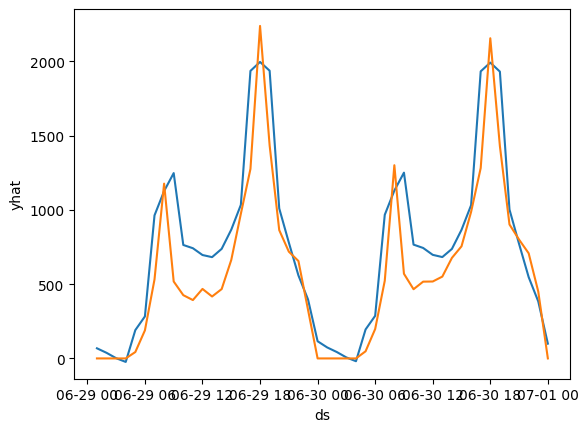

In [92]:
sns.lineplot(x=prediction['ds'], y=prediction['yhat'])
sns.lineplot(x=df_achasan5_test['ds'], y=df_achasan5_test['y'])

mape(prediction['yhat'].values, df_achasan5_test['y'].values)


/Users/thomas_metral/.pyenv/versions/3.10.6/envs/metro_seoul/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/thomas_metral/.pyenv/versions/3.10.6/envs/metro_seoul/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


NameError: name 'df_achasan5_test' is not defined

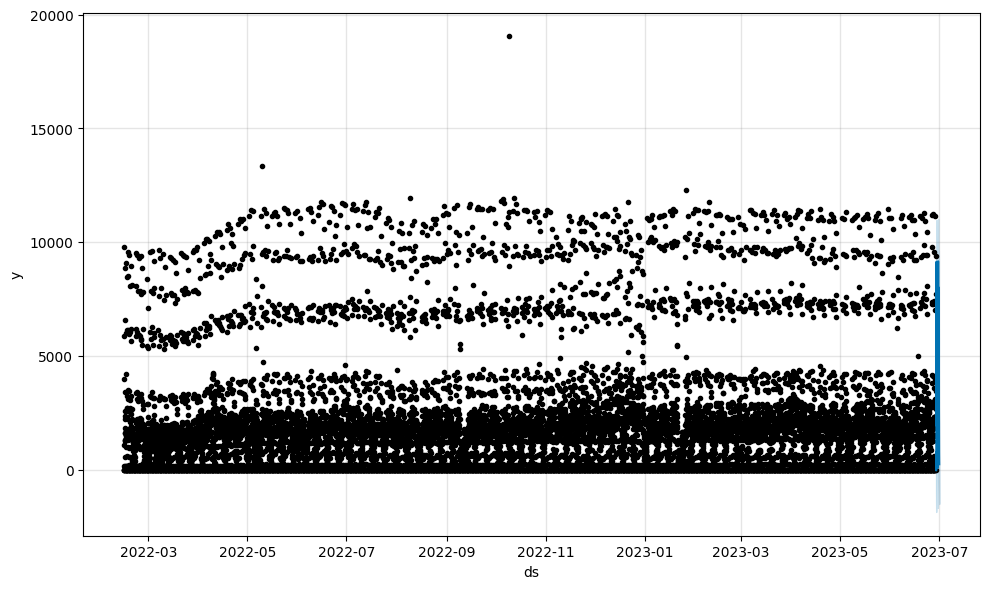

In [19]:
ax = model.plot(forecast)
plt.plot(df_achasan5_test['ds'],df_achasan5_test['y'],'r')
plt.xlim(left=(pd.Timestamp(max(df_achasan5.ds)-datetime.timedelta(days=5))),
right=(pd.Timestamp(max(df_achasan5.ds)+ datetime.timedelta(days=1)))
)
plt.show()


### Cross Validation with grid search

In [34]:
param_grid = {
    'changepoint_prior_scale': [0.001, 0.002, 0.003],
    'seasonality_prior_scale': [10.0, 12.0, 20.0],
    'holidays_prior_scale' : [9.0, 10.0, 15.0],
    'seasonality_mode' : ['multiplicative']

}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params)  # Fit model with given params
    m.add_country_holidays(country_name='KR')
    m.add_regressor('is_morning_peak')
    m.add_regressor('is_afternoon_peak')
    m.add_regressor('is_closed')
    m.fit(df_achasan5_train)
    df_cv = cross_validation(m, initial='400 days', period='100 days', horizon = '2 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)
tuning_results.iloc[rmses.index(min(rmses))]


14:14:00 - cmdstanpy - INFO - Chain [1] start processing
14:14:00 - cmdstanpy - INFO - Chain [1] done processing
14:14:01 - cmdstanpy - INFO - Chain [1] start processing
14:14:02 - cmdstanpy - INFO - Chain [1] done processing
14:14:02 - cmdstanpy - INFO - Chain [1] start processing
14:14:03 - cmdstanpy - INFO - Chain [1] done processing
14:14:04 - cmdstanpy - INFO - Chain [1] start processing
14:14:04 - cmdstanpy - INFO - Chain [1] done processing
14:14:05 - cmdstanpy - INFO - Chain [1] start processing
14:14:05 - cmdstanpy - INFO - Chain [1] done processing
14:14:06 - cmdstanpy - INFO - Chain [1] start processing
14:14:07 - cmdstanpy - INFO - Chain [1] done processing
14:14:07 - cmdstanpy - INFO - Chain [1] start processing
14:14:08 - cmdstanpy - INFO - Chain [1] done processing
14:14:08 - cmdstanpy - INFO - Chain [1] start processing
14:14:09 - cmdstanpy - INFO - Chain [1] done processing
14:14:09 - cmdstanpy - INFO - Chain [1] start processing
14:14:10 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                     0.001                     10.0                   9.0   
1                     0.001                     10.0                  10.0   
2                     0.001                     10.0                  15.0   
3                     0.001                     12.0                   9.0   
4                     0.001                     12.0                  10.0   
5                     0.001                     12.0                  15.0   
6                     0.001                     20.0                   9.0   
7                     0.001                     20.0                  10.0   
8                     0.001                     20.0                  15.0   
9                     0.002                     10.0                   9.0   
10                    0.002                     10.0                  10.0   
11                    0.002                     10.0            

14:15:14 - cmdstanpy - INFO - Chain [1] done processing


changepoint_prior_scale             0.003
seasonality_prior_scale              12.0
holidays_prior_scale                 10.0
seasonality_mode           multiplicative
rmse                           159.299028
Name: 22, dtype: object

In [35]:

np.sqrt(mean_squared_error(prediction['yhat'].values, df_achasan5_test['y'].values))


251.06858634542422

In [36]:
df_p


,horizon,mse,rmse,mae,mdape,smape,coverage
0,2 days,26063.986303,161.443446,125.170957,0.217973,0.604893,0.895833
